# Simple 2D motion planning and profile generation for wheeled mobile robots (Python demonstration)
by Vlad Chira 

## References


## Contents

Motion planning for mobile robots includes at least these very basic steps:   
- Path planning - given a set of points (called knots), we must construct a continuous path that passes through all the points in the order they were given   

    
- Motion profile generation - given a path and the kinematic constraints of a mobile robot, we need to construct *a path-constrained, kinematic-constrained, time-optimal motion profile*   

## Path Planning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['figure.dpi'] = 150

### What is interpolation?

Interpolation is a technique used to estimate values within a set of known data points. It involves creating a function or curve that passes through these data points and then using that function to predict the values at points that lie between the given data points. In essence, interpolation allows us to "fill in the gaps" between the known data points and make educated guesses about the values at intermediate positions.   


Let's assume that we know the values of an unknown function $f(x)$ at certain points:
$f(1) = 2 \ \ ; \ \ f(2) = 3 \ \ ; \ \ f(4) = 7 \ \ ; \ \ f(6) = 5 \ \ ; \ \ f(8) = 11 \ \ ; \ \ $   
Now, we are tasked with calculating $f(1.5) , f(3), f(5), f(7)$   

It is clear that it is impossible to know what those values actually are in this case (but it some cases - not relevant here - it can, see Nyquist–Shannon sampling theorem).   

Our best bet is to try to make an educated guess somehow. A simple way is to find a polynomial of degree n-1 (where n is the number of known points) that passes through all these points. This boils down to solving a system of equations. Given the 5 points above, we need a polynomial of degree 4 $p(x)$. Solving for it: 

In [2]:
# ax^4 + bx^3 + cx^2 + dx + e
# a + b + c + d + e = 2
# a*16 + b*8 + c*4 + d*2 + e = 3
# a*256 + b*64 + c*16 + d*4 + e = 7
# a*1296 + b*216 + c*36 + d*6 + e = 5
# a*4096 + b*512 + c*64 + d*8 + e = 11

Another approach, called *linear interpolation*, is to assume that the function is a straight line between two adjacent points. 

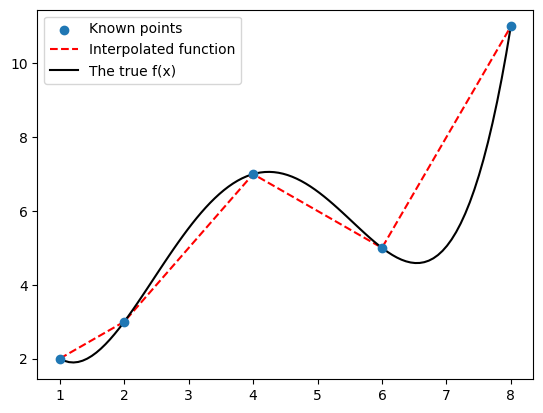

In [3]:
def plot_lines(x, y):
    plt.scatter(x, y, zorder=10, label='Known points')
    # Note: the line below just lets matplotlib handle the interpolation
    plt.plot(x, y, color='r', linestyle='dashed', label='Interpolated function')

known_x = [1, 2, 4, 6, 8]
known_y = [2, 3, 7, 5, 11]

# known_x = [1, 2, 2.8, 4, 6, 7, 8]
# known_y = [2, 3, 5.055, 7, 5, 5.0358, 11]
plot_lines(known_x, known_y)

# Plot the 'true' f(x)
x = np.linspace(1, 8, 100)
real_y = 6.885714 - 9.714286*x + 5.916667*x**2 - 1.160714*x**3 + 0.07261905*x**4
plt.plot(x, real_y, color='black', label='The true f(x)')
plt.legend()
plt.show()

It's not a bad approximation overall, but definitely not exactly like the true function. We let matplotlib handle the linear interpolation (because that is how the plot() function works) for the demonstration. Let's go through the math ourselves now:   
We can approach this from the algebraic point of view: we know that a line is a first degree polynomial, $g(x) = ax + b$ and that it passes through two points, for example: $g(1)=2, g(2)=3$. Solving the system for $a$ and $b$ will gives us the equation of the line passing through (1,2) and (2,3).   


### What are splines?


A point in our configuration space can be represented as 3-tuple (x, y, θ) - corresponding to the position in a 2D Cartesian plane and a heading - which from now on will be referred to as ”pose”.   
For holonomic robots, heading can be treated independently from position in Cartesian space, and for non-holonomic robots, the heading must always be constrained to the direction of movement i.e. tangent to the path.   
Consequently, we will restrict the discussion of creating paths to the 2D Cartesian plane and tackle heading interpolation later.


The almost universal way of representing path or curves is with splines. The choice of splines is, however, a topic of debate. What is sure, however, is that we desire a spline type that is made up of individual segments, each with plenty of 'flexibility'. This 'flexibility' can be thought of as shaping the path into exactly what we need with ease and without introducing additional knots. To skip over the details (that are very interesting), which you can find here[1], we will use *quintic splines*. Each segment is made up of a parametric polynomial of maximum degree 5.  (i.e. the polynomial ring $\mathbb{R}_5[X]$) 

### Quintic polynomials

Let's begin by defining the QuinticPolynomial class. We need to be able to set the coefficients and to evaluate the polynomial at a particular value. We also calculate the first and second derivative because we will need them when interpolating.   
It's worth mentioning that the polynomials have a *maximum* degree of 5, but they can be of a smaller degree as well.

In [4]:
class QuinticPolynomial:
    def __init__(self, args):
            if len(args) != 6:
                 raise ValueError('Incorrect polynomial given')
            self.a = args[0]
            self.b = args[1]
            self.c = args[2]
            self.d = args[3]
            self.e = args[4]
            self.f = args[5]

    def eval(self, t):
        return self.a * t**5 + self.b * t**4 + self.c * t**3 + self.d * t**2 + self.e * t + self.f

    def first_deriv(self):
        return QuinticPolynomial([0, 5 * self.a, 4 * self.b, 3 * self.c, 2 * self.d, self.e])

    def second_deriv(self):
        return QuinticPolynomial([0, 0, 20 * self.a, 12 * self.b, 6 * self.c, 2 * self.d])

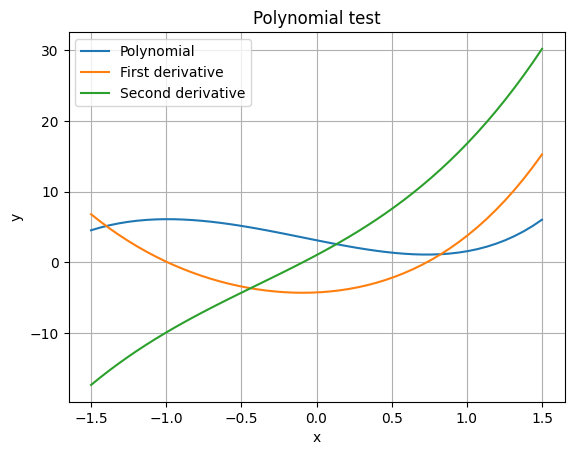

In [5]:
polynomial = QuinticPolynomial([0.1, 0.2, 1.89, 0.51, -4.26, 3.12])
first_deriv = polynomial.first_deriv()
second_deriv = polynomial.second_deriv()

known_x = np.linspace(-1.5, 1.5, 50)
y0 = polynomial.eval(known_x)
y1 = first_deriv.eval(known_x)
y2 = second_deriv.eval(known_x)

plt.plot(known_x, y0, known_x, y1, known_x, y2)
plt.title('Polynomial test')
plt.grid(True)
plt.legend(['Polynomial', 'First derivative', 'Second derivative'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

The kind of curve we described above is called an **explicit curve**. An explicit equation defines one variable directly in terms of another variable and it has the general equation $y=f(x)$.

### Parametric curves

We cannot use the polynomial in its explicit form, i.e. y = p(x) to create the curve between two knots because such a curve imposes a huge limitation on the amount of curves we can describe. It just doesn't have the 'flexibility' we want. What we actually want is to use parametric curves, curves in which both x and y are dependent on a *parameter*, usually called *t* **in the range [0,1]**. The basic idea is that, because each coordinate can vary independently with respect to the parameter **t** it allows for more control over the curve's behavior. For example:
$$ x(t) = 2t(1 + t^2)\\ y(t) = 2t^2 \\ where \ t \in [0,1]$$
would create the curve (a special case of the Cissoid of Diocles):

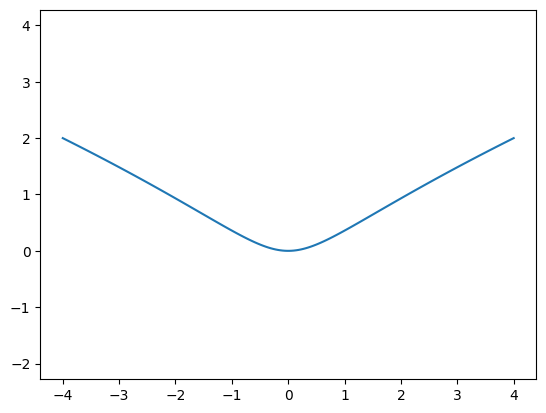

In [6]:
t = np.linspace(-1, 1, 100)
known_x = 2 * t * (1 + t**2)
known_y = 2 * t**2

plt.plot(known_x, known_y)
plt.axis('equal')
plt.show()

Let's return to a single explicit 5th degree polynomial for a moment. As I have said above, the spline is made up of segments. A segment will interpolate between two adjacent knots. However, there are an infinite number of fifth degree polynomials that pass through two points.   
Mathematically this happens because plugging in the points (0,1) and (1,0) in the equation of the polynomial only gives us a relationship between the coefficients but not their actual values.   
Let $p(x) = ax^5 + bx^4 + cx^3 + dx^2 + ex + f$ our fifth degree polynomial. It must pass through (0,1), so $p(0) = 1 \Rightarrow f = 1$.   
It must also pass through (1,0) so $f(1) = 0 \Rightarrow a + b + c + d + e + f = 0$, but $f=1$ so therefore   
$a + b + c + d + e = -1, \ f = 1 $   

It is obvious that there are an infinite amount of numbers a, b, c, d , e that satisfy the equation.
Let's confirm this is the case with an example:

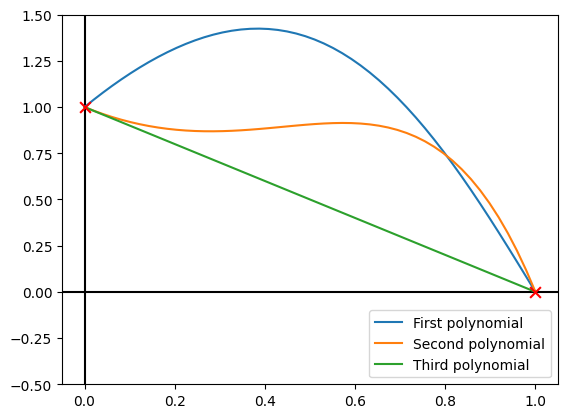

In [7]:
# Let these points be (0,1) and (1,0)
plt.scatter([0, 1], [1, 0], color='red', marker='x', s=60, zorder=10, label='_nolegend_')

# It's easy to find two or more polynomials with max degree 5 that pass through these 2 points
p1 = QuinticPolynomial([2, -3, 0, -2, 2, 1])
p2 = QuinticPolynomial([-1, -1, 0, 2, -1, 1])
p3 = QuinticPolynomial([0, 0, 0, 0, -1, 1])

known_x = np.linspace(0, 1, 50)
y1 = p1.eval(known_x)
y2 = p2.eval(known_x)
y3 = p3.eval(known_x)

plt.plot(known_x, y1, known_x, y2, known_x, y3,  zorder=5)
plt.legend(['First polynomial', 'Second polynomial', 'Third polynomial'])
plt.ylim([-0.5, 1.5])
plt.axhline(0, color='black')
plt.axvline(0, color='black')

plt.show()

What we see from the plot above is that we need to impose additional constraints on the polynomial we calculate so that we get one and *only one* polynomial for the interpolation.  

We can safely say that this is also the case with a parametric curve made up of 5th degree polynomials: there is an infinite amount of such curves interpolating two points.   
Here is where the 'flexibility' part comes in. The additional constraints we impose are the first and second derivatives at the start and end knots. For now, let's assume the second derivative is always 0. It doesn't have much influence on the final path anyways and it also lets us focus on the first derivative which is very important.

### Exploring the first derivative of parametric curves